In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

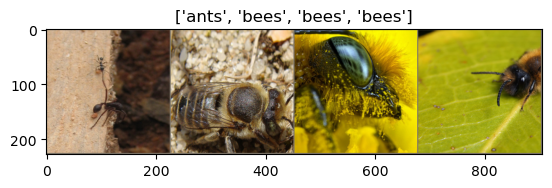

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


## L1 Regularization

In [5]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)


In [7]:
import copy
import torch
import time
from torch import nn, optim
from torch.optim import lr_scheduler


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # Removed weight_decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25,lambda_l1=0.01):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Add L1 regularization
                    l1_penalty = 0.0
                    for param in model.parameters():
                        l1_penalty += torch.sum(torch.abs(param))
                    loss += lambda_l1 * l1_penalty

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,lambda_l1=0.03)


Epoch 0/24
----------
train Loss: 12720.6505 Acc: 0.4713
val Loss: 2224.5424 Acc: 0.5425

Epoch 1/24
----------
train Loss: 1724.9312 Acc: 0.5697
val Loss: 1513.5811 Acc: 0.5425

Epoch 2/24
----------
train Loss: 1470.0072 Acc: 0.4795
val Loss: 1442.1293 Acc: 0.4575

Epoch 3/24
----------
train Loss: 1418.7501 Acc: 0.4631
val Loss: 1397.8691 Acc: 0.5425

Epoch 4/24
----------
train Loss: 1389.3731 Acc: 0.4631
val Loss: 1396.1452 Acc: 0.5425

Epoch 5/24
----------
train Loss: 1360.0336 Acc: 0.4795
val Loss: 1359.6075 Acc: 0.4575

Epoch 6/24
----------
train Loss: 1333.1093 Acc: 0.4959
val Loss: 1306.1523 Acc: 0.4575

Epoch 7/24
----------
train Loss: 385.9258 Acc: 0.5451
val Loss: 218.2809 Acc: 0.5425

Epoch 8/24
----------
train Loss: 213.2053 Acc: 0.4467
val Loss: 213.7627 Acc: 0.5425

Epoch 9/24
----------
train Loss: 209.6140 Acc: 0.4303
val Loss: 208.2542 Acc: 0.5425

Epoch 10/24
----------
train Loss: 206.8033 Acc: 0.4467
val Loss: 205.6228 Acc: 0.4575

Epoch 11/24
----------
trai

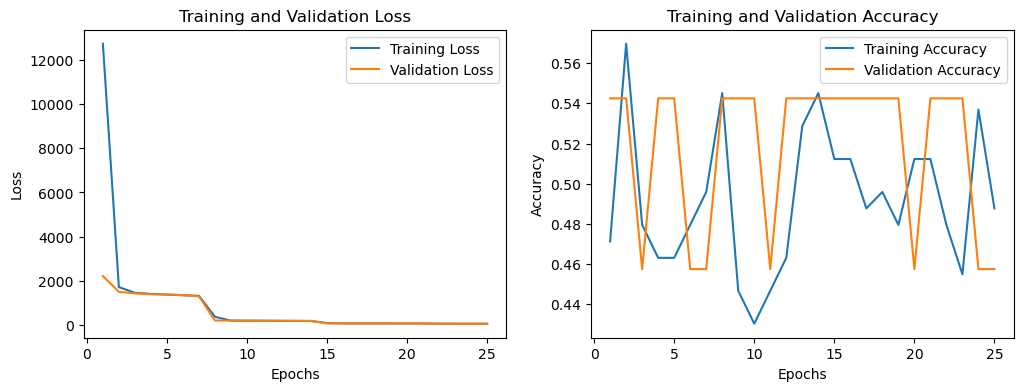

In [8]:
# Plotting the loss and accuracy
epochs = range(1, 26)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label='Training Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label='Training Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        # Sample a few images from the validation loader
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

# Call the function to visualize predictions
visualize_predictions(model_ft)

NameError: name 'model_ft' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

In [ ]:
import subprocess
subprocess.run(['git', 'add', '.'])
subprocess.run(['git', 'commit', '-m', 'Updated readme'])
subprocess.run(['git', 'push'])

CompletedProcess(args=['git', 'push'], returncode=0)

END 